In [ ]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .


Mounted at /content/drive


# Preprocessing

## Imports

In [ ]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

tf.keras.backend.clear_session()

## Parameters

In [ ]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288
# 576x432
# 512x384
input_res = (384, 288)

seed = 42

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-3,                      
          'momentum': 0.98,                        
          'nEpoches': 100,                        
          }

ratio_test = 0.85
ratio_val  = 0.8

lib.create_dump([params, seed], dumps_path + "params_du")

type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

## Data loading 

In [ ]:
# LOAD & SPLIT DATA ============================================================
'''
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")

'''

'\nmode = 1  #\xa0mode = 0: Random Split\n          #\xa0mode = 1: Split for Patients\n          \ndataset_list = lib.get_dataset_list(\n                                mode, \n                                path_, \n                                imgs_list_path, \n                                params, \n                                ratio_test, \n                                ratio_val, \n                                seed, \n                                modality)\n\n# Dumping splitted data\nlib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")\n\n'

##Loading Data from Pickle

In [ ]:
dataset_list = pickle.load(open( f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}", "rb" ))

##Data Augmentation

In [ ]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

In [ ]:
print(params["length_training"])
print(params['length_validation'])
print(len(dataset_list[0]['test']))

# Model definition & training

## Training

In [ ]:
params['learningRate'] = 1e-3
params['nEpoches'] = 100


models_name = ['unet', 'lightweight_unet', 'dbunet', 'dbunet_BNDrop', 'dbunet_BN']
arch_name = models_name[4]
model_weights = f"{root_path}/dataset/results/models/{arch_name}_Glorot_e{params['nEpoches']}_lr{params['learningRate']}"
log_path = f"{model_weights}/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf $log_path
!cp "$root_path/modules/models/{arch_name}.py" .
arch = importlib.import_module(arch_name)
'''if 'dbunet' in arch_name:
  model = arch.build_model(input_size)
else:'''


input_size = (input_res[1], input_res[0], 1)
initializer = tf.keras.initializers.GlorotUniform()
model = arch.build_model(initializer, input_size)
#model.summary()

In [ ]:
# Model savepath
#now = datetime.now()
#current_time = now.strftime("%H:%M:%S")

# Default loss, metric
#loss = 'binary_crossentropy'
#metric = 'accuracy'
loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

print(f'Model wil be saved in {model_weights}')

train_history, model = lib.train(model_weights, log_path, params, model, loss, metric, train_generator, val_generator)


Model wil be saved in /content/drive/MyDrive/CVDL/dataset/results/models/dbunet_BN_Glorot_e100_lr0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
21/21 [==============================] - 36s 1s/step - loss: 1.4699 - dice: 0.0233 - iou: 0.0106 - recall: 0.0479 - precision: 0.0311 - val_loss: 1.6561 - val_dice: 0.0222 - val_iou: 8.0712e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.65615, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/dbunet_BN_Glorot_e100_lr0.001/Model.hdf5
Epoch 2/100
21/21 [==============================] - 12s 589ms/step - loss: 1.2469 - dice: 0.0342 - iou: 5.2360e-06 - recall: 4.9391e-06 - precision: 0.0090 - val_loss: 1.4860 - val_dice: 0.0203 - val_iou: 9.3318e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: val_loss improved from 1.65615 to 1.48605, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/dbunet_BN_Glorot_e100_lr0.001/Model.hdf5
Epoch 3/100
21/21 [==============================] - 12s 559ms/step - loss: 1.0461 - dice: 0.0760 - iou: 1.0244e-08 - recall: 0.0000e+00 - precis

## Evaluating

2/2 [==============================] - 1s 212ms/step - loss: 0.1147 - dice: 0.8860 - iou: 0.8145 - recall: 0.8499 - precision: 0.9460


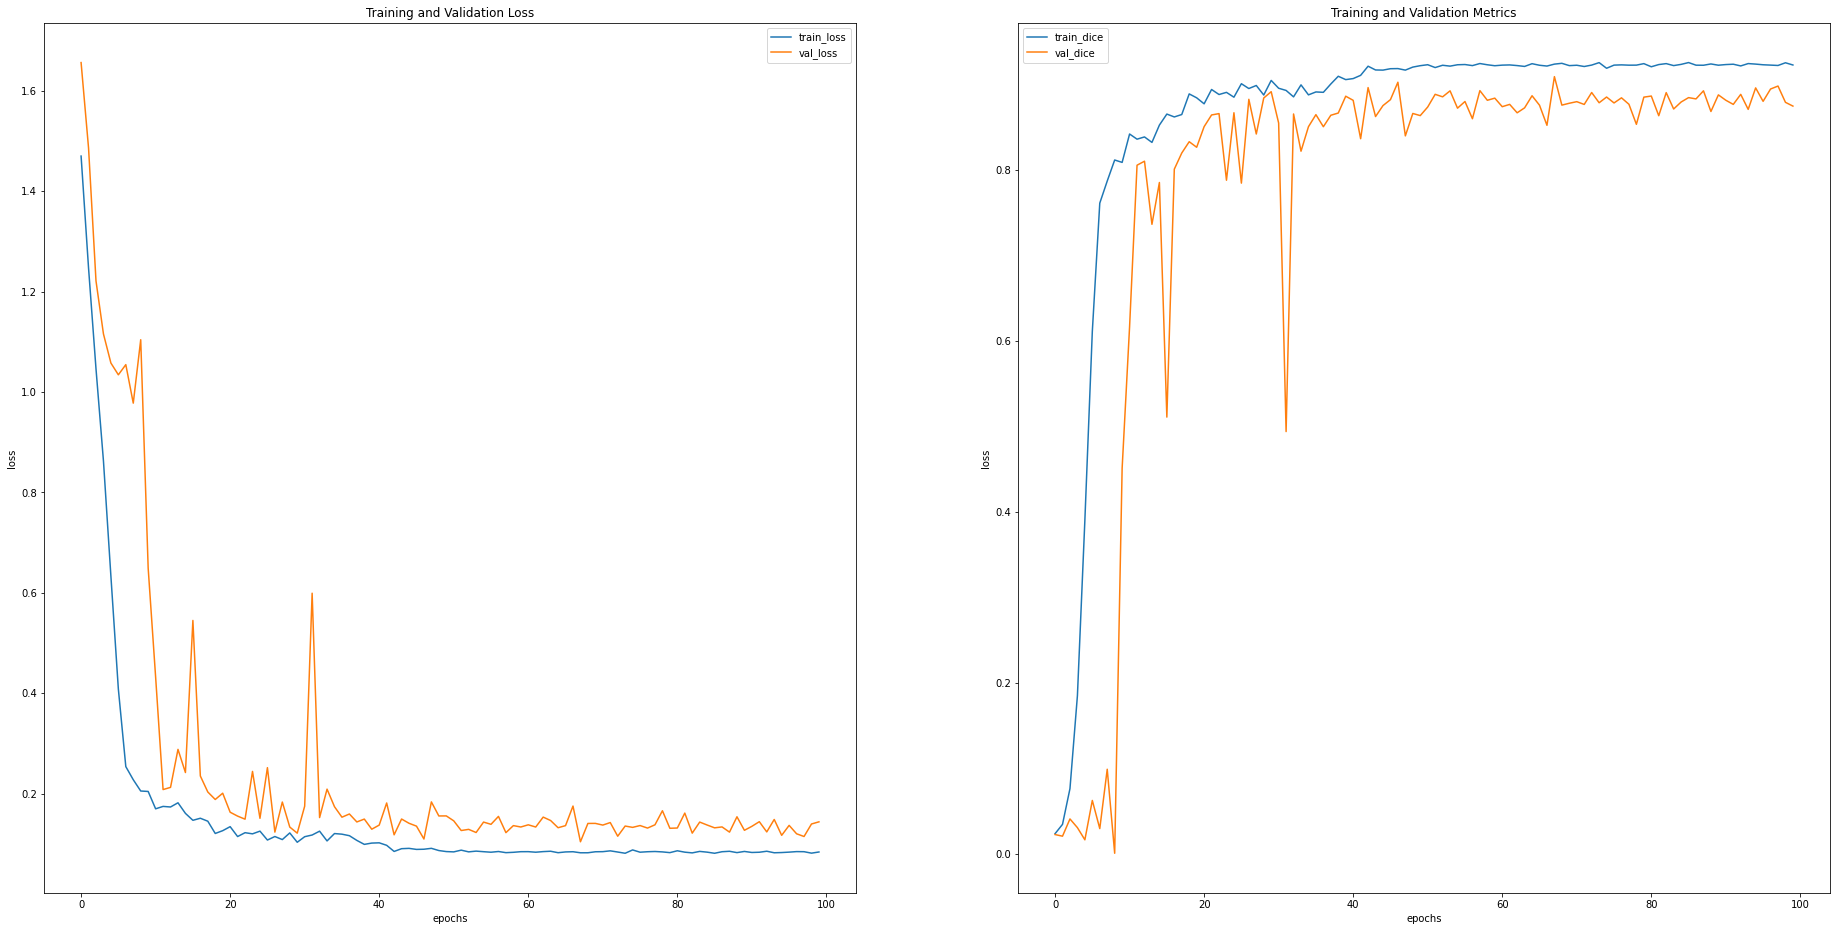

In [ ]:
results_tf = model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)
train_figure = plots.plot_train_metric(train_history, params['nEpoches'], "dice")
plt.show()

In [ ]:
threshold = 0.5
min_dice = 0.60
results_df, avg = plots.get_results(dataset_list, params, model, threshold)
print(results_df)
print('\n')
print(f"Threshold value: {threshold}")
print(f"Best dice: {max(results_df['dice'])}")
print(f"Average dice: {avg}")
print(f"Minimum requested dice value (bad samples): {min_dice}")
good_res = results_df.loc[(results_df['dice'] >= min_dice)]
print(f"Average dice without bad samples: {good_res['dice'].mean()}")

        dice
0   0.860024
1   0.925186
2   0.930312
3   0.913642
4   0.945693
5   0.945473
6   0.913196
7   0.908168
8   0.938356
9   0.937937
10  0.937313
11  0.904893
12  0.926339
13  0.908891
14  0.950678
15  0.935342
16  0.928763
17  0.941118
18  0.879325
19  0.814163
20  0.898998
21  0.924149
22  0.944255
23  0.959441
24  0.932267
25  0.936741
26  0.928105
27  0.923182
28  0.907796
29  0.932954
30  0.812667
31  0.956646
32  0.705882
33  0.943216
34  0.880884
35  0.947687
36  0.926745
37  0.893691
38  0.904203
39  0.825234
40  0.905782
41  0.906819
42  0.799389
43  0.677693


Threshold value: 0.5
Best dice: 0.9594405594405594
Average dice: {'dice': 0.9027099356017142}
Minimum requested dice value (bad samples): 0.6
Average dice without bad samples: 0.9027099356017142


In [ ]:
bad_res = results_df.loc[(results_df['dice'] < min_dice)]
print(bad_res)

num = bad_res['dice'].count()
den = results_df['dice'].count()

print(num/den)
print('\n')
print("Loading bad samples... :")
print('\n')
for idx in bad_res.index:
  print('\n')
  print('\n')
  print(f"Image index {idx} - dice: {bad_res.loc[idx]}")
  threshold = 0.5
  test_image = dataset_list[0]['test'][idx,:,:,0]
  test_mask = dataset_list[1]['test'][idx,:,:,0]
  test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)
  results_figure = plots.plot_test_results(test_results)

  plt.show()
#results_figure.savefig(f'/content/drive/MyDrive/CVDL/trained_models/{name}/bad_samples.png')

Empty DataFrame
Columns: [dice]
Index: []
0.0


Loading bad samples... :




In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 384, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 288, 384, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 288, 384, 64) 1792        concatenate[0][0]                
______________________________________________________________________________________________

## Saving

In [ ]:
name = 'doubleunet_d0.9027'
model.save(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.h5', save_format='h5')
lib.create_dump(train_history.history, f'/content/drive/MyDrive/CVDL/trained_models/{name}/train_history')

In [ ]:
from tensorflow import keras

c_objects = {
    "bce_dice_loss": metrics.bce_dice_loss,
    "dice": metrics.dice,
    "iou": metrics.iou,
    "precision": tf.keras.metrics.Precision(),
    "recall": tf.keras.metrics.Recall(),
}

loaded_model = keras.models.load_model(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.h5', custom_objects=c_objects)

loaded_model.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)

results_tf = loaded_model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)

2/2 [==============================] - 4s 212ms/step - loss: 0.1147 - dice: 0.8860 - iou: 0.8145 - recall: 0.8499 - precision: 0.9460
